## Baseline Model for predicting Galaxy Parameters

### Algorithm

1. *Take a noisy galaxy image (atmosphere noise, CCD noise & image shear)* <br><br>
2. *From the image, estimate noise level (sigma) and PSF* <br><br>
Theoretically, we can do the following<br>
2a. Noise can be estimated by looking at a object free location in the image<br>
2b. PSF can be estimated by locating a star in the image (using an existing database), and its rendering approximates the PSF <br><br>
However, for our case, we have noise and PSF stored in the generated training data<br><br>
3. *Create an objective function* <br><br>
*Inputs:*<br>
Observed image<br>
Current estimates of parameters<br><br>
*Calculate Loss:*<br>
We generate an image using Galsim and the estimated parameters . <br>
From this we calculate the (negative) log likelihood. We are basically taking the $log$ of $P(Image | Parameters)$. We take the negative of this to get the minimization objective.<br>
<br>
4. *Optimize the loss function*<br>
We use scipy.minimise, with `L-BFGS-B` algorithm. `nelder-mead` & `BFGS` do not support bounds, and lead to generation of "invalid" values of parameters during the minimization process, when we use Galsim to generate model images<br><br>

**References**<br>
1. mfit: A Fast, Flexible New Program for Astronomical Image Fitting (https://arxiv.org/abs/1408.1097)


In [1]:
import numpy as np
import pandas as pd
import galsim
import matplotlib.pyplot as plt
import numpy as np 
import random
import copy
import time

In [2]:
random_seed = 1314662
image_size = 64 # n x n pixels
pixel_scale = 0.23 # arcsec / pixel
psf_beta = 2 # moffat parameter

In [3]:
# dataset is not essential. Being used to have similar prediction data as NN approach
# however, we can easily generate sample noisy images using galsim for this

dataset = "../data/data_v1.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf_r = data["psf_r"]

labels = pd.DataFrame(label, columns=["flux", "sersic index", "sersic radius", "g1", "g2"])

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'psf_img', 'snr', 'sigma']


### Objective Function

In [4]:
def objective_function(x, image, psf_re, psf_beta, sigma, LL_type='MSE'):
    """Object Function for normalization. Returns the -2*Log Likelihood

    Args:
        x(packed as a tuple): (flux, sersic index, sersic radius, g1, g2). Algorithm changes this every iteration
        image: image from which parameters are to be estimated. It could be generated / true captured data
        psf_re & psf_beta: characterizing the telescope & atmosphere. Estimated from image
        sigma: noise level estimated from image
        LL_type: Log Likelihood calculation approach
    """
    
    gal_flux = x[0] # flux
    bulge_n = x[1] # sersic index
    bulge_re = x[2] # sersic radius
    g_1 = x[3]
    g_2 = x[4]
    gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    gal = gal.withFlux(gal_flux)
    gal = gal.shear(g1=g_1, g2=g_2)
    
    psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   

    obs = galsim.Convolve([psf, gal])
    img_obs = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    obs.drawImage(image=img_obs);

    rng = galsim.BaseDeviate(random_seed)
#     img_obs.addNoise(galsim.PoissonNoise(rng, sky_level=0.))
    img_obs.addNoise(galsim.GaussianNoise(rng, sigma=sigma))
    
    # default MSE
    LL = np.sum((image - img_obs.array)**2)
    
    if LL_type == 'MSE':
        LL = np.sum((image - img_obs.array)**2)
    if LL_type == "Norm_MSE": # Normalized MSE with sigma
        LL = np.sum((image - img_obs.array)**2/sigma**2)
    if LL_type == 'NormModel_MSE': # Normalized MSE with sigma & CCD/Poisson Noise, estimated from Model
        LL = np.sum(np.divide((image - img_obs.array)**2,(img_obs.array + sigma**2)))
    if LL_type == "NormData_MSE": # Normalized MSE with sigma & CCD/Poisson Noise, estimated from Data
        LL = np.sum(np.divide((image - img_obs.array)**2,(image + sigma**2)))
    if LL_type == "Complete": # Complete Form
        LL = np.sum(np.divide((image - img_obs.array)**2,(image + sigma**2)) + \
                2*np.log((np.sqrt(2*np.pi)*(image + sigma**2))))

    return LL

    

### Predict parameters for noisy images with SNR 60

In [5]:
from scipy.optimize import minimize

no_of_images = 100 # no of images to optimize

pred_df = pd.DataFrame(columns=["flux", "sersic index", "sersic radius", "g1", "g2"]) # prediction results
org_df = pd.DataFrame(columns=["flux", "sersic index", "sersic radius", "g1", "g2"]) # original parameters
img_indices = [] # indices of images for which estimation is being carried out

next_img = 0
SNR = 60 # SNR for which estimation is carried out
tol = 2 # SNR search tolerance

print("SrNo\tImgIndex\tSNR\tSuccess\tLLVal")
start_time = int(round(time.time() * 1000))

for i in range(no_of_images):
    
    # look for images with required SNR +/- tol
    while not ((SNR-tol < snr[next_img]) and (SNR+tol > snr[next_img])):
        next_img += 1
    img_index = next_img

    # gal_flux, bulge_n, bulge_re, g_1, g_2
    # initialize flux with sum of all pixel values, as gaussian noise would have zero mean
    # init sersic index to 3, sersic radius to 0.3, g1 & g2 to 0 (no shear)
    x_init = [image[img_index].sum(), 3, 0.3, 0., 0.]
    
    # bounds for parameter
    bounds = [(0.3*1e5, 4*1e5), (0.5, 6), (0.1, 0.6), (-0.6, 0.6), (-0.6, 0.6)]

    # 'nelder-mead' is extremely slow
    # 'nelder-mead' & 'BFGS' do not support bounds, and lead to generation of "invalid" values of parameters
    # using 'L-BFGS-B' as it supports bounds
    
    # we are passing psf_r, psf_beta and sigma as these are parameters that can be estimated from a given image
    # psf by looking at stars in the image (from know locations of stars) and using that as psf
    # noise by look at objectless location of image. assumption is that noise is gaussian
    # additionally CCD / Poisson noise can be estimated as sqrt(pixel value) in image / modelled image
    
    res = minimize(fun=objective_function, x0=x_init, \
                   args=(image[img_index], psf_r[img_index], psf_beta, sigma[img_index], "NormData_MSE"), \
                   bounds=bounds, method='L-BFGS-B', options={'disp': True, 'eps': 0.0005})
#                    method='nelder-mead', options={'disp': True, 'adaptive': True})
#                    method='BFGS', options={'disp': True, 'eps': 0.01})
#                    jac=objective_function_der, bounds=bounds, method='L-BFGS-B', options={'disp': True, 'eps': 0.05})

    # save predictions
    pred_df.loc[img_index] = res.x
    # save original parameters
    org_df.loc[img_index] = [labels['flux'][img_index], labels['sersic index'][img_index], \
                              labels['sersic radius'][img_index], labels['g1'][img_index], labels['g2'][img_index]]

    print(i, img_index, snr[img_index], res.success, res.fun, sep='\t')
    # store image index
    img_indices.append(next_img)

    next_img += 1

end_time = int(round(time.time() * 1000))

print("average estimation time = {0:.0f} msec".format((end_time - start_time)/no_of_images))

SrNo	ImgIndex	SNR	Success	LLVal
0	36	61.727837	True	8032.617
1	62	58.65117	True	8350.691
2	75	59.48493	True	8247.448
3	117	59.67363	True	8316.232
4	146	58.92065	True	8169.5225
5	172	59.262413	True	8223.681
6	190	60.3118	True	8353.768
7	252	59.648426	True	8528.914
8	297	60.652035	True	8157.305
9	355	59.03044	True	8137.497
10	361	58.576492	True	8091.555
11	444	58.51529	True	8342.984
12	445	58.730038	True	8334.9375
13	450	60.00717	True	8005.1406
14	483	58.319427	True	8318.853
15	498	58.704662	False	8322.397
16	554	59.774532	True	8285.727
17	559	60.9271	True	8318.221
18	570	58.608597	True	8380.279
19	571	60.97724	True	8280.832
20	574	61.917953	True	8065.2095
21	587	58.61585	True	8092.7183
22	610	59.294544	True	8124.4053
23	640	60.494335	True	8633.449
24	659	61.278877	True	7984.384
25	689	58.448135	True	8187.2285
26	691	61.393143	True	8234.551
27	752	61.305843	True	8372.617
28	773	59.483505	True	8070.671
29	778	61.802235	True	8333.697
30	802	61.0767	True	8222.409
31	852	58.314243	True	7997.

In [ ]:
# display(pred_df)
# display(org_df)
# img_indices = [36,62,75,117,146,172,190,252,297,355]

### Calculate mean & SD of error

In [7]:
mean = (org_df - pred_df).describe().iloc[1].values # mean error
mean[0] /= 1e5 # scale flux by 1e5
# print(mean)

sd = (pred_df - org_df).describe().iloc[2].values # sd of error
sd[0] /= 1e5 # scale flux by 1e5
# print(sd)

# store result in dataframe
res_df = pd.DataFrame(columns=['mean', 'sd'], index=["flux[1e5]", "sersic index", "sersic radius", "g1", "g2"])
res_df['mean'] = mean
res_df['sd'] = sd

display(res_df)

res_df_SNR60 = res_df

,mean,sd
flux[1e5],0.014457,0.120346
sersic index,-0.168781,1.165510
sersic radius,0.016616,0.063026
g1,0.015684,0.057815
g2,-0.085064,0.087334


In [11]:
def create_image(x, img_index):
    """Create a (noiseless) image using galsim

    Args:
        x(packed as a tuple): (flux, sersic index, sersic radius, g1, g2).
        img_index: index of image from our dataset. We can avoid this by storing these values too like other parameters!
    """    
    
    gal_flux = x[0] # flux
    bulge_n = x[1] # sersic index
    bulge_re = x[2] # sersic radius
    g_1 = x[3]
    g_2 = x[4]

    psf_re = psf_r[img_index]
    image_ = image[img_index]
    image_nonoise_ = image_nonoise[img_index]
    sigma_ = sigma[img_index]

    gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    gal = gal.withFlux(gal_flux)
    gal = gal.shear(g1=g_1, g2=g_2)

    psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   

    img_psf = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    psf.drawImage(image=img_psf);

    obs = galsim.Convolve([psf, gal])
    img_obs = galsim.ImageF(image_size, image_size, scale=pixel_scale)
    obs.drawImage(image=img_obs);
    
    return img_obs.array

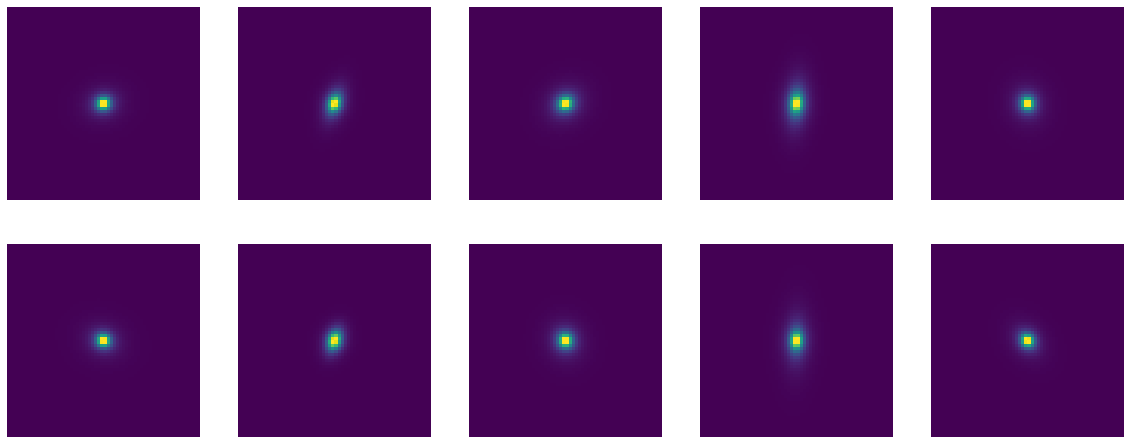

In [15]:
# plot some predictions
# note that we are plotting noiseless / PSF free Galaxy images both for orginal & predicted

plt_count = 5
s = 0 # start plotting from

fig, ax = plt.subplots(2, plt_count, figsize=(4*plt_count, 4*2))
ax = ax.ravel()

for i in range(plt_count):
    ax[i].imshow(create_image(org_df.iloc(0)[s+i].values, img_indices[s+i]))
    ax[i].axis("off")
    
    ax[plt_count+i].imshow(create_image(pred_df.iloc(0)[s+i].values, img_indices[s+i]))
    ax[plt_count+i].axis("off")

Row no.1 is the noiseless images, corresponding to the noisy images that were input to the optimise routine.<br>
Row no.2 is the noiseless images, generated using GALSIM with predicted parameters<br>

### Predict parameters for noisy images with SNR 30

In [16]:
from scipy.optimize import minimize

no_of_images = 100 # no of images to optimize

pred_df = pd.DataFrame(columns=["flux", "sersic index", "sersic radius", "g1", "g2"]) # prediction results
org_df = pd.DataFrame(columns=["flux", "sersic index", "sersic radius", "g1", "g2"]) # original parameters
img_indices = [] # indices of images for which estimation is being carried out

next_img = 0
SNR = 30 # SNR for which estimation is carried out
tol = 2 # SNR search tolerance

print("SrNo\tImgIndex\tSNR\tSuccess\tLLVal")
start_time = int(round(time.time() * 1000))

for i in range(no_of_images):
    
    # look for images with required SNR +/- tol
    while not ((SNR-tol < snr[next_img]) and (SNR+tol > snr[next_img])):
        next_img += 1
    img_index = next_img

    # gal_flux, bulge_n, bulge_re, g_1, g_2
    # initialize flux with sum of all pixel values, as gaussian noise would have zero mean
    # init sersic index to 3, sersic radius to 0.3, g1 & g2 to 0 (no shear)
    x_init = [image[img_index].sum(), 3, 0.3, 0., 0.]
    
    # bounds for parameter
    bounds = [(0.3*1e5, 4*1e5), (0.5, 6), (0.1, 0.6), (-0.6, 0.6), (-0.6, 0.6)]

    # 'nelder-mead' is extremely slow
    # 'nelder-mead' & 'BFGS' do not support bounds, and lead to generation of "invalid" values of parameters
    # using 'L-BFGS-B' as it supports bounds
    
    # we are passing psf_r, psf_beta and sigma as these are parameters that can be estimated from a given image
    # psf by looking at stars in the image (from know locations of stars) and using that as psf
    # noise by look at objectless location of image. assumption is that noise is gaussian
    # additionally CCD / Poisson noise can be estimated as sqrt(pixel value) in image / modelled image
    
    res = minimize(fun=objective_function, x0=x_init, \
                   args=(image[img_index], psf_r[img_index], psf_beta, sigma[img_index], "NormData_MSE"), \
                   bounds=bounds, method='L-BFGS-B', options={'disp': True, 'eps': 0.0005})
#                    method='nelder-mead', options={'disp': True, 'adaptive': True})
#                    method='BFGS', options={'disp': True, 'eps': 0.01})
#                    jac=objective_function_der, bounds=bounds, method='L-BFGS-B', options={'disp': True, 'eps': 0.05})

    # save predictions
    pred_df.loc[img_index] = res.x
    # save original parameters
    org_df.loc[img_index] = [labels['flux'][img_index], labels['sersic index'][img_index], \
                              labels['sersic radius'][img_index], labels['g1'][img_index], labels['g2'][img_index]]

    print(i, img_index, snr[img_index], res.success, res.fun, sep='\t')
    # store image index
    img_indices.append(next_img)

    next_img += 1

end_time = int(round(time.time() * 1000))

print("average estimation time = {0:.0f} msec".format((end_time - start_time)/no_of_images))

SrNo	ImgIndex	SNR	Success	LLVal
0	29	28.309586	True	8462.975
1	34	30.902937	True	8324.199
2	54	30.727716	True	8304.559
3	65	29.353676	True	8301.514
4	86	31.960342	True	8331.379
5	92	31.486563	True	8301.232
6	95	29.570934	True	8203.188
7	122	29.903772	True	8065.8677
8	133	29.105644	True	8551.163
9	134	30.442131	True	8452.893
10	151	30.141113	True	8540.281
11	165	30.45152	True	8236.94
12	176	29.459906	True	8068.5137
13	189	28.946589	True	8192.981
14	213	28.488806	True	8386.756
15	230	29.694477	True	8466.705
16	258	31.642096	True	8315.455
17	291	31.86498	True	8303.94
18	341	30.28998	True	8138.956
19	369	30.917473	True	8132.343
20	390	28.982605	True	8247.811
21	408	28.520054	True	8233.318
22	411	31.052458	False	8198.301
23	439	28.200537	True	8443.209
24	456	30.240833	True	8243.608
25	457	31.690191	True	8403.561
26	474	29.985502	True	8411.368
27	517	28.765425	True	8132.3174
28	518	30.152102	True	8311.118
29	531	31.980846	True	8478.799
30	548	28.048471	True	8458.34
31	592	28.208538	True	8370

In [17]:
mean = (org_df - pred_df).describe().iloc[1].values # mean error
mean[0] /= 1e5 # scale flux by 1e5
# print(mean)

sd = (pred_df - org_df).describe().iloc[2].values # sd of error
sd[0] /= 1e5 # scale flux by 1e5
# print(sd)

# store result in dataframe
res_df = pd.DataFrame(columns=['mean', 'sd'], index=["flux[1e5]", "sersic index", "sersic radius", "g1", "g2"])
res_df['mean'] = mean
res_df['sd'] = sd

display(res_df)

res_df_SNR30 = res_df

,mean,sd
flux[1e5],0.017031,0.126301
sersic index,-0.183291,2.307567
sersic radius,0.044020,0.133119
g1,0.055584,0.132233
g2,-0.184911,0.169390


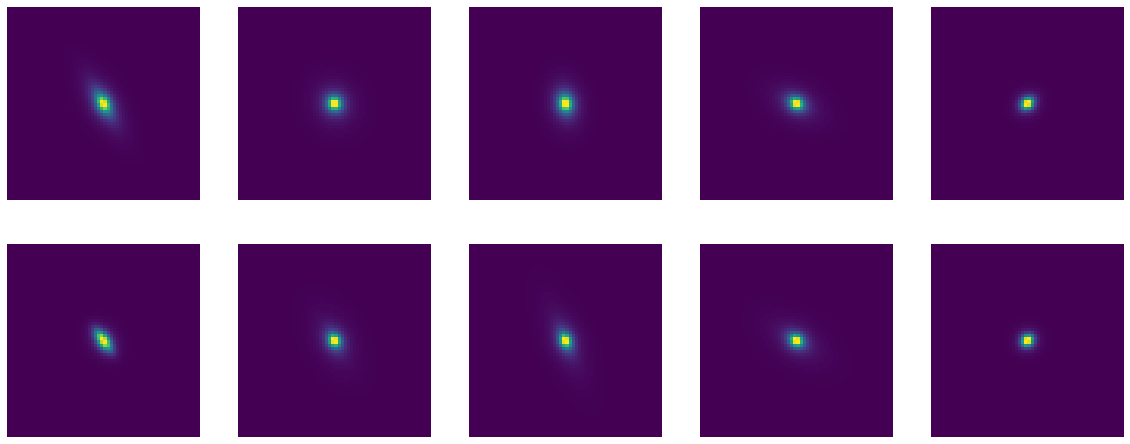

In [18]:
# plot some predictions
# note that we are plotting noiseless / PSF free Galaxy images both for orginal & predicted

plt_count = 5
s = 0 # start plotting from

fig, ax = plt.subplots(2, plt_count, figsize=(4*plt_count, 4*2))
ax = ax.ravel()

for i in range(plt_count):
    ax[i].imshow(create_image(org_df.iloc(0)[s+i].values, img_indices[s+i]))
    ax[i].axis("off")
    
    ax[plt_count+i].imshow(create_image(pred_df.iloc(0)[s+i].values, img_indices[s+i]))
    ax[plt_count+i].axis("off")

Row no.1 is the noiseless images, corresponding to the noisy images that were input to the optimise routine.<br>
Row no.2 is the noiseless images, generated using GALSIM with predicted parameters<br>


### <div class="theme"> Performance Evaluation: Test Data vs Caramer-Rao Bound (NN & Baseline Models) </div>
<img src="../Project/graphs/CRB_with_Baseline.png" style="width: 900px;"/>
<img style="float: right; padding-left: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">